# Classifying NC vs PAE - Pre-trained SFCN Model - Using Processed MRI

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nibabel as nib
from scipy.stats import norm
from scipy.ndimage import zoom
from scipy.ndimage import rotate
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from monai.data import Dataset, ArrayDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, AddChanneld, RandRotated, Lambda, ToTensor

In [2]:
# Keeping all file names in the list.
NC_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\NC_Resized_122_MRI"
PAE_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\PAE_Resized_MRI"

in_X = []
out_y = []

for file_name in os.listdir(NC_MRI_path):
    in_X.append(NC_MRI_path + "/" + file_name)
    out_y.append(0)
    
for file_name in os.listdir(PAE_MRI_path):
    in_X.append(PAE_MRI_path + "/" + file_name)
    out_y.append(1)
    
print(len(in_X), len(out_y))

244 244


In [3]:
X = []
y = []

for i in range(0, len(in_X), +1):
    mri = nib.load(in_X[i])
    data = mri.get_fdata()
    
    # Adding an extra dimension at the begining. From (160,192,160) to (1,160,192,160).
    data = data[np.newaxis, ...]
    
    X.append(data)
    y.append(out_y[i])
    
# Converting to numpy array.   
X = np.array(X)
y = np.array(y)

print(X[0].shape)
print(y[0].shape)

(1, 160, 192, 160)
()


# Simple Fully Convolutional Network (SFCN) Architecture

In [4]:
class SFCN(nn.Module):
    def __init__(self, channel_number):  # channel_number = [28, 58, 128, 256, 256, 64]
        super(SFCN, self).__init__()
        
        n_layer = len(channel_number)
        
        self.feature_extractor = nn.Sequential()
        
        for i in range(n_layer):
            if i == 0:
                in_channel = 1
            else:
                in_channel = channel_number[i-1]
                
            out_channel = channel_number[i]
            
            if i < n_layer-1:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 1))
            else:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = False, kernel_size = 1, padding = 0))
    
    
    @staticmethod
    def conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 0, maxpool_stride = 2):
        if maxpool is True:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.MaxPool3d(2, stride=maxpool_stride),
                nn.ReLU(),
            )
        else:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.ReLU()
            )
        return layer
    

    def forward(self, input_image):
        extracted_features = self.feature_extractor(input_image) 
        
        return extracted_features   #shape: [64,5,6,5]
    

channel_number = [28, 58, 128, 256, 256, 64] # Sex-prediction
#channel_number = [32, 64, 128, 256, 256, 64] # Brain-Age-prediction

model = SFCN(channel_number)

# Loading pre-trained model - Removing weights and biases for Classification Part

In [5]:
tm = "BSP_run_20191008_00_epoch_last.p" # Pre-trained model aka weights and biases of already trained model for sex prediction.
#tm = "BAP_run_20190719_00_epoch_best_mae.p" # This is for Brain Age prediction.
state_dict = torch.load(tm)

for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [6]:
# Removing weight and bias (parameters) of classifier layer.
state_dict.pop('module.classifier.conv_6.weight', None)
state_dict.pop('module.classifier.conv_6.bias', None)

tensor([ 0.0604, -0.0605], device='cuda:0')

In [7]:
# Printing weights and biases parameter shape after removing classifier.
for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [8]:
# Loading after removing the classificaiton part
model.load_state_dict(state_dict, strict = False)
model

SFCN(
  (feature_extractor): Sequential(
    (conv_0): Sequential(
      (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_1): Sequential(
      (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_2): Sequential(
      (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_3): Seque

# Freezing Feature Extraction Layers of Pre-trained SFCN Model

In [9]:
for param in model.parameters():
    param.requires_grad = False

# Adding a Classification Layer on Top of SFCN Architecture

In [10]:
def create_model():
    # Number of node in the final layer
    num_classes = 1

    # Defining the modified model by adding layers
    modified_model = nn.Sequential(
        model, # pre-trained SFCN model (feature extractor) for feature extraction
        nn.Flatten(),
        nn.Linear(9600, 512),  # number of output features from the pre-trained model: 64*5*6*5 = 9600
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
        nn.Sigmoid()  # Using Sigmoid activation for binary classification
    )
    
    return modified_model

modified_model = create_model()
modified_model

Sequential(
  (0): SFCN(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

# Creating Dataset, Dataloader -- 5-Fold Train-Val-Test

In [11]:
# 5-Fold cross-validation method to train, validate and test the model
n_folds = 5
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

# Initializing list to keep info of each fold
train_loss_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []

# Initializing lists to store results for all folds
all_true_labels = []
all_predicted_labels = []
fold_sensitivities = []
fold_specificities = []
    
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}:\n")
    
    # Creating train, val, test dataset
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=fold+1)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=fold+1)
    
    train_data_dict = [{"mri": a, "label": b} for a, b in zip(X_train, y_train)]
    val_data_dict = [{"mri": a, "label": b} for a, b in zip(X_val, y_val)]
    test_data_dict = [{"mri": a, "label": b} for a, b in zip(X_test, y_test)]
    
    train_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            ToTensor()
        ])

    val_test_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            ToTensor()
        ])

    train_dataset = Dataset(train_data_dict, train_transforms)
    val_dataset = Dataset(val_data_dict, val_test_transforms)
    test_dataset = Dataset(test_data_dict, val_test_transforms)

    
    train_count_zero = len(y_train) - np.count_nonzero(y_train)
    train_count_one = np.count_nonzero(y_train)
    val_count_zero = len(y_val) - np.count_nonzero(y_val)
    val_count_one = np.count_nonzero(y_val)
    test_count_zero = len(y_test) - np.count_nonzero(y_test)
    test_count_one = np.count_nonzero(y_test)
    
    print("NC and PAE ratio in training dataset: ", [train_count_zero, train_count_one])
    print("NC and PAE ratio in validation dataset: ", [val_count_zero, val_count_one])
    print("NC and PAE ratio in testing dataset: ", [test_count_zero, test_count_one])
    print("\n")
    
    # create the datasets and dataloaders
    #train_dataset = Creating_Dataset(X_train, y_train)
    #val_dataset = Creating_Dataset(X_val, y_val)
    #test_dataset = Creating_Dataset(X_test, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Initializing model. Need to initialize the model for each fold.
    modified_model = create_model()

    # Defining the loss function, optimizer, and metrics
    loss_fn = nn.BCELoss() #for sigmoind, output channel = 1
    optimizer = torch.optim.Adam(modified_model.parameters(), lr=0.001)
    
    # Creating list to keep loss and acc for each epoch
    train_loss_100epochs = []
    val_loss_100epochs = []
    test_acc_100epochs = []
    
    # Initializing lists to store results for each epoch in the fold
    fold_true_labels = []
    fold_predicted_labels = []

    num_epochs = 100

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        ############### Training on Train Set ###############
        modified_model.train()
        modified_model.cuda()

        for train_batch_idx, train_batch_data in enumerate(train_dataloader):
            train_input, train_actual_output = train_batch_data["mri"], train_batch_data["label"]
                                    
            train_input = train_input.cuda()
            train_actual_output = train_actual_output.cuda()

            optimizer.zero_grad()
            
            # Forward pass
            train_pred_output = modified_model(train_input)
            loss = loss_fn(train_pred_output, train_actual_output)

            # Backward and optimize
            loss.backward()
            train_loss = train_loss + loss.item()
            optimizer.step()

        train_loss = train_loss / (train_batch_idx + 1)

        ############### Evaluating on Validation Set ###############
        with torch.no_grad():
            modified_model.eval()
            modified_model.cuda()
            
            for val_batch_idx, val_batch_data in enumerate(val_dataloader):
                val_input, val_actual_output = val_batch_data["mri"], val_batch_data["label"]
                
                val_input = val_input.cuda()
                val_actual_output = val_actual_output.cuda()

                val_pred_output = modified_model(val_input)
                loss = loss_fn(val_pred_output, val_actual_output)
                val_loss = val_loss + loss.item()

            val_loss = val_loss / (val_batch_idx + 1)
        
        ############### Testing on Test Set ###############
        with torch.no_grad():
            total_sample = 0
            test_accuracy_total = 0

            for test_batch_data in test_dataloader:
                test_input, test_actual_output = test_batch_data["mri"], test_batch_data["label"]
                
                test_input = test_input.cuda()
                test_actual_output = test_actual_output.cuda()

                test_pred_output = modified_model(test_input)
                test_pred_output = torch.round(test_pred_output)
                
                # Append true and predicted labels for each sample in the test set
                fold_true_labels.extend(test_actual_output.cpu().numpy())
                fold_predicted_labels.extend(test_pred_output.cpu().numpy())

                # Calculating accuracy
                total_sample += test_actual_output.size(0)
                test_accuracy_total += (test_pred_output == test_actual_output).sum().item()

            accuracy = 100 * test_accuracy_total / total_sample

        train_loss_100epochs.append(train_loss)
        val_loss_100epochs.append(val_loss)
        test_acc_100epochs.append(accuracy)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(epoch+1, train_loss, val_loss, accuracy))
    
    # Keeping loss for each fold. Each fold has the loss for 100 epochs.
    train_loss_per_fold.append(train_loss_100epochs)
    val_loss_per_fold.append(val_loss_100epochs)
    
    # Keeping the Average accuracy for each fold. (sum of 100 epochs accuracy / 100 epochs)
    test_acc_per_fold.append(np.mean(test_acc_100epochs))
    
    # Calculate confusion matrix, sensitivity, and specificity for the current fold
    fold_confusion_matrix = confusion_matrix(fold_true_labels, fold_predicted_labels)
    tn, fp, fn, tp = fold_confusion_matrix.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print or store the results for the current fold
    print(f'Fold {fold+1} - Sensitivity: {sensitivity}, Specificity: {specificity}')

    # Append the true and predicted labels for the current fold to the overall lists
    all_true_labels.extend(fold_true_labels)
    all_predicted_labels.extend(fold_predicted_labels)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)
    
# Concatenate the confusion matrices from all folds
all_confusion_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
tn, fp, fn, tp = all_confusion_matrix.ravel()

overall_sensitivity = tp / (tp + fn)
overall_specificity = tn / (tn + fp)

# Print or store the overall results
print(f'\nOverall Sensitivity: {overall_sensitivity}, Overall Specificity: {overall_specificity}')
print(f'Average Sensitivity across folds: {np.mean(fold_sensitivities)}, Average Specificity across folds: {np.mean(fold_specificities)}')


Fold 1:

NC and PAE ratio in training dataset:  [92, 103]
NC and PAE ratio in validation dataset:  [17, 8]
NC and PAE ratio in testing dataset:  [13, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.981880 	Validation Loss: 0.794498 	Test Accuracy: 45.833333
Epoch: 2 	Training Loss: 1.035536 	Validation Loss: 0.846044 	Test Accuracy: 45.833333
Epoch: 3 	Training Loss: 0.647117 	Validation Loss: 0.496350 	Test Accuracy: 91.666667
Epoch: 4 	Training Loss: 0.507864 	Validation Loss: 0.560213 	Test Accuracy: 62.500000
Epoch: 5 	Training Loss: 0.403810 	Validation Loss: 0.420889 	Test Accuracy: 83.333333
Epoch: 6 	Training Loss: 0.310550 	Validation Loss: 0.376847 	Test Accuracy: 87.500000
Epoch: 7 	Training Loss: 0.274786 	Validation Loss: 0.370191 	Test Accuracy: 83.333333
Epoch: 8 	Training Loss: 0.225142 	Validation Loss: 0.435500 	Test Accuracy: 70.833333
Epoch: 9 	Training Loss: 0.292553 	Validation Loss: 0.323339 	Test Accuracy: 83.333333
Epoch: 10 	Training Loss: 0.216682 	Validation Loss: 0.507124 	Test Accuracy: 62.500000
Epoch: 11 	Training Loss: 0.142486 	Validation Loss: 0.269296 	Test Accuracy: 91.666667
Epoch: 12 	Training Loss: 0.098605 	Valid

Epoch: 95 	Training Loss: 0.066891 	Validation Loss: 0.248920 	Test Accuracy: 91.666667
Epoch: 96 	Training Loss: 0.067379 	Validation Loss: 0.176140 	Test Accuracy: 95.833333
Epoch: 97 	Training Loss: 0.036298 	Validation Loss: 0.238446 	Test Accuracy: 91.666667
Epoch: 98 	Training Loss: 0.067925 	Validation Loss: 0.259282 	Test Accuracy: 91.666667
Epoch: 99 	Training Loss: 0.054697 	Validation Loss: 0.327146 	Test Accuracy: 83.333333
Epoch: 100 	Training Loss: 0.046671 	Validation Loss: 0.237534 	Test Accuracy: 87.500000
Fold 1 - Sensitivity: 0.9263636363636364, Specificity: 0.7807692307692308

Fold 2:

NC and PAE ratio in training dataset:  [95, 100]
NC and PAE ratio in validation dataset:  [14, 11]
NC and PAE ratio in testing dataset:  [13, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.749394 	Validation Loss: 2.131413 	Test Accuracy: 45.833333
Epoch: 2 	Training Loss: 1.097446 	Validation Loss: 0.732225 	Test Accuracy: 70.833333
Epoch: 3 	Training Loss: 0.654881 	Validation Loss: 0.882038 	Test Accuracy: 83.333333
Epoch: 4 	Training Loss: 0.413947 	Validation Loss: 0.867995 	Test Accuracy: 83.333333
Epoch: 5 	Training Loss: 0.338587 	Validation Loss: 0.658627 	Test Accuracy: 66.666667
Epoch: 6 	Training Loss: 0.286087 	Validation Loss: 0.788951 	Test Accuracy: 83.333333
Epoch: 7 	Training Loss: 0.220207 	Validation Loss: 0.603316 	Test Accuracy: 66.666667
Epoch: 8 	Training Loss: 0.243589 	Validation Loss: 0.739956 	Test Accuracy: 87.500000
Epoch: 9 	Training Loss: 0.172893 	Validation Loss: 0.764552 	Test Accuracy: 87.500000
Epoch: 10 	Training Loss: 0.125509 	Validation Loss: 1.026945 	Test Accuracy: 83.333333
Epoch: 11 	Training Loss: 0.127144 	Validation Loss: 0.665596 	Test Accuracy: 87.500000
Epoch: 12 	Training Loss: 0.116911 	Valid

Epoch: 95 	Training Loss: 0.067634 	Validation Loss: 1.047644 	Test Accuracy: 91.666667
Epoch: 96 	Training Loss: 0.043222 	Validation Loss: 1.157034 	Test Accuracy: 62.500000
Epoch: 97 	Training Loss: 0.111249 	Validation Loss: 1.553408 	Test Accuracy: 87.500000
Epoch: 98 	Training Loss: 0.043098 	Validation Loss: 0.918521 	Test Accuracy: 83.333333
Epoch: 99 	Training Loss: 0.026108 	Validation Loss: 0.924192 	Test Accuracy: 83.333333
Epoch: 100 	Training Loss: 0.068217 	Validation Loss: 0.949769 	Test Accuracy: 75.000000
Fold 2 - Sensitivity: 0.8781818181818182, Specificity: 0.8338461538461538

Fold 3:

NC and PAE ratio in training dataset:  [100, 95]
NC and PAE ratio in validation dataset:  [10, 15]
NC and PAE ratio in testing dataset:  [12, 12]




C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 2.241097 	Validation Loss: 1.320267 	Test Accuracy: 50.000000
Epoch: 2 	Training Loss: 1.053596 	Validation Loss: 0.604403 	Test Accuracy: 70.833333
Epoch: 3 	Training Loss: 0.622115 	Validation Loss: 0.497874 	Test Accuracy: 75.000000
Epoch: 4 	Training Loss: 0.470038 	Validation Loss: 0.566289 	Test Accuracy: 70.833333
Epoch: 5 	Training Loss: 0.421610 	Validation Loss: 0.476102 	Test Accuracy: 87.500000
Epoch: 6 	Training Loss: 0.283081 	Validation Loss: 0.375686 	Test Accuracy: 91.666667
Epoch: 7 	Training Loss: 0.279671 	Validation Loss: 0.517664 	Test Accuracy: 66.666667
Epoch: 8 	Training Loss: 0.255988 	Validation Loss: 0.468133 	Test Accuracy: 70.833333
Epoch: 9 	Training Loss: 0.167814 	Validation Loss: 0.354014 	Test Accuracy: 95.833333
Epoch: 10 	Training Loss: 0.134212 	Validation Loss: 0.361409 	Test Accuracy: 91.666667
Epoch: 11 	Training Loss: 0.117965 	Validation Loss: 0.257102 	Test Accuracy: 91.666667
Epoch: 12 	Training Loss: 0.087987 	Valid

Epoch: 95 	Training Loss: 0.045774 	Validation Loss: 0.206361 	Test Accuracy: 91.666667
Epoch: 96 	Training Loss: 0.042950 	Validation Loss: 0.261304 	Test Accuracy: 100.000000
Epoch: 97 	Training Loss: 0.048739 	Validation Loss: 0.232713 	Test Accuracy: 91.666667
Epoch: 98 	Training Loss: 0.038146 	Validation Loss: 0.206149 	Test Accuracy: 95.833333
Epoch: 99 	Training Loss: 0.056520 	Validation Loss: 0.209891 	Test Accuracy: 95.833333
Epoch: 100 	Training Loss: 0.030725 	Validation Loss: 0.210558 	Test Accuracy: 87.500000
Fold 3 - Sensitivity: 0.8991666666666667, Specificity: 0.9525

Fold 4:

NC and PAE ratio in training dataset:  [93, 102]
NC and PAE ratio in validation dataset:  [16, 9]
NC and PAE ratio in testing dataset:  [13, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.804915 	Validation Loss: 0.476383 	Test Accuracy: 50.000000
Epoch: 2 	Training Loss: 0.947616 	Validation Loss: 0.451055 	Test Accuracy: 62.500000
Epoch: 3 	Training Loss: 0.536193 	Validation Loss: 0.380457 	Test Accuracy: 75.000000
Epoch: 4 	Training Loss: 0.433302 	Validation Loss: 0.389545 	Test Accuracy: 70.833333
Epoch: 5 	Training Loss: 0.318833 	Validation Loss: 0.311943 	Test Accuracy: 83.333333
Epoch: 6 	Training Loss: 0.260094 	Validation Loss: 0.327212 	Test Accuracy: 75.000000
Epoch: 7 	Training Loss: 0.265645 	Validation Loss: 0.394347 	Test Accuracy: 70.833333
Epoch: 8 	Training Loss: 0.169606 	Validation Loss: 0.230201 	Test Accuracy: 91.666667
Epoch: 9 	Training Loss: 0.137729 	Validation Loss: 0.174878 	Test Accuracy: 91.666667
Epoch: 10 	Training Loss: 0.113999 	Validation Loss: 0.201919 	Test Accuracy: 91.666667
Epoch: 11 	Training Loss: 0.070664 	Validation Loss: 0.419235 	Test Accuracy: 70.833333
Epoch: 12 	Training Loss: 0.042717 	Valid

Epoch: 95 	Training Loss: 0.068992 	Validation Loss: 0.130940 	Test Accuracy: 83.333333
Epoch: 96 	Training Loss: 0.106368 	Validation Loss: 0.285880 	Test Accuracy: 79.166667
Epoch: 97 	Training Loss: 0.079687 	Validation Loss: 0.350450 	Test Accuracy: 70.833333
Epoch: 98 	Training Loss: 0.081622 	Validation Loss: 0.286396 	Test Accuracy: 79.166667
Epoch: 99 	Training Loss: 0.077224 	Validation Loss: 0.139397 	Test Accuracy: 91.666667
Epoch: 100 	Training Loss: 0.048144 	Validation Loss: 0.110743 	Test Accuracy: 91.666667
Fold 4 - Sensitivity: 0.860909090909091, Specificity: 0.7546153846153846

Fold 5:

NC and PAE ratio in training dataset:  [94, 101]
NC and PAE ratio in validation dataset:  [14, 11]
NC and PAE ratio in testing dataset:  [14, 10]




C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_11360\1174945202.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 2.106168 	Validation Loss: 0.849631 	Test Accuracy: 41.666667
Epoch: 2 	Training Loss: 0.816545 	Validation Loss: 0.524494 	Test Accuracy: 83.333333
Epoch: 3 	Training Loss: 0.588626 	Validation Loss: 0.443712 	Test Accuracy: 87.500000
Epoch: 4 	Training Loss: 0.424365 	Validation Loss: 0.380750 	Test Accuracy: 79.166667
Epoch: 5 	Training Loss: 0.399873 	Validation Loss: 0.355408 	Test Accuracy: 83.333333
Epoch: 6 	Training Loss: 0.349402 	Validation Loss: 0.405576 	Test Accuracy: 83.333333
Epoch: 7 	Training Loss: 0.309613 	Validation Loss: 0.256785 	Test Accuracy: 79.166667
Epoch: 8 	Training Loss: 0.194890 	Validation Loss: 0.394958 	Test Accuracy: 70.833333
Epoch: 9 	Training Loss: 0.156219 	Validation Loss: 0.258855 	Test Accuracy: 91.666667
Epoch: 10 	Training Loss: 0.115509 	Validation Loss: 0.145930 	Test Accuracy: 83.333333
Epoch: 11 	Training Loss: 0.113428 	Validation Loss: 0.231279 	Test Accuracy: 83.333333
Epoch: 12 	Training Loss: 0.096752 	Valid

Epoch: 95 	Training Loss: 0.068812 	Validation Loss: 0.165626 	Test Accuracy: 95.833333
Epoch: 96 	Training Loss: 0.067348 	Validation Loss: 0.223625 	Test Accuracy: 91.666667
Epoch: 97 	Training Loss: 0.104280 	Validation Loss: 0.289812 	Test Accuracy: 75.000000
Epoch: 98 	Training Loss: 0.087223 	Validation Loss: 0.095836 	Test Accuracy: 91.666667
Epoch: 99 	Training Loss: 0.171285 	Validation Loss: 0.127344 	Test Accuracy: 95.833333
Epoch: 100 	Training Loss: 0.147405 	Validation Loss: 0.121568 	Test Accuracy: 95.833333
Fold 5 - Sensitivity: 0.862, Specificity: 0.8992857142857142

Overall Sensitivity: 0.886, Overall Specificity: 0.8433846153846154
Average Sensitivity across folds: 0.8853242424242425, Average Specificity across folds: 0.8442032967032966


In [12]:
all_confusion_matrix

array([[5482, 1018],
       [ 627, 4873]], dtype=int64)

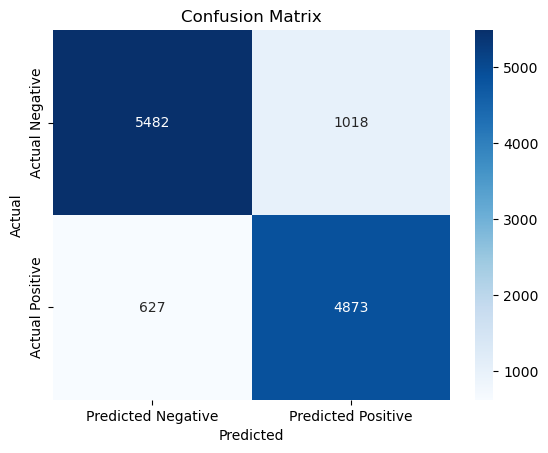

In [13]:
sns.heatmap(all_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Results Visualization

In [14]:
# printing training loss for each fold.
avg_train_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(train_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_train_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Train Loss = {}, Average Train Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Train Loss = 0.10950532457935105, Average Train Accuracy = 0.890494675420649
Fold 2: Average Train Loss = 0.10546250021003159, Average Train Accuracy = 0.8945374997899684
Fold 3: Average Train Loss = 0.11183122976282286, Average Train Accuracy = 0.8881687702371771
Fold 4: Average Train Loss = 0.09701365152682265, Average Train Accuracy = 0.9029863484731774
Fold 5: Average Train Loss = 0.1332396200457592, Average Train Accuracy = 0.8667603799542408


In [15]:
# printing validation loss for each fold.
avg_val_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(val_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_val_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Validation Loss = {}, Average Validation Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Validation Loss = 0.2982760110977397, Average Validation Accuracy = 0.7017239889022603
Fold 2: Average Validation Loss = 0.8954258296190528, Average Validation Accuracy = 0.10457417038094718
Fold 3: Average Validation Loss = 0.2719892639080354, Average Validation Accuracy = 0.7280107360919645
Fold 4: Average Validation Loss = 0.2507130137573986, Average Validation Accuracy = 0.7492869862426015
Fold 5: Average Validation Loss = 0.1750234478127677, Average Validation Accuracy = 0.8249765521872323


In [16]:
# Printing test set accuracy for each fold.
for value in test_acc_per_fold:
    print(value)

84.75
85.41666666666669
92.58333333333334
80.33333333333334
88.375


In [17]:
# Average accuracy
np.mean(test_acc_per_fold)

86.29166666666667

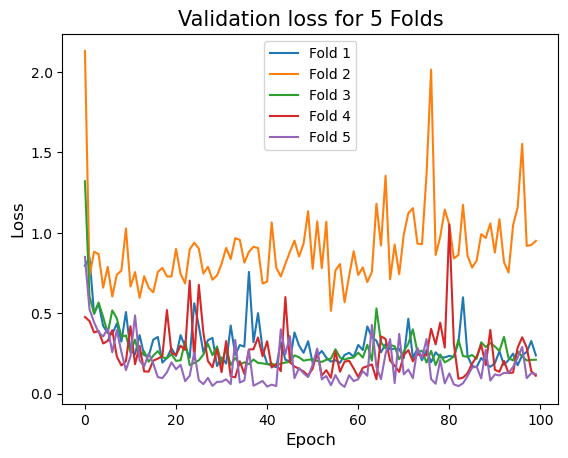

In [18]:
n_folds = len(val_loss_per_fold)
n_epochs = len(val_loss_per_fold[0])

# plot each fold's accuracy as a line plot with a different color
for i in range(n_folds):
    plt.plot(range(n_epochs), val_loss_per_fold[i], label=f"Fold {i+1}")

# set plot title, axis labels, and legend
plt.title("Validation loss for 5 Folds", fontsize = 15)
plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()

plt.show()

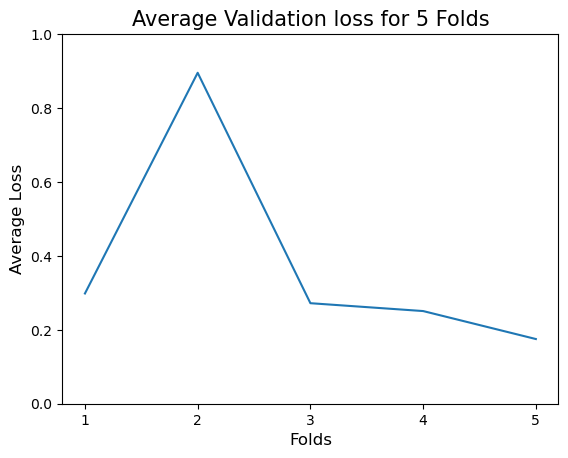

In [19]:
# Plotting the data
plt.plot(range(1, len(avg_val_loss_per_fold) + 1), avg_val_loss_per_fold)
plt.xticks(range(1, len(avg_val_loss_per_fold) + 1))

# Set y-axis range
plt.ylim(0, 1.0)

# Set plot title, axis labels, and legend
plt.title("Average Validation loss for 5 Folds", fontsize=15)
plt.xlabel("Folds", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)

# Display the plot
plt.show()

In [21]:
final_model_save_path = r'C:\Users\anikd\Desktop\NC_vs_PAE\final_model_no-aug_122scans.pth'
torch.save(modified_model.state_dict(), final_model_save_path)